# Introduction

In November 2022, I got a cat with my girlfriend (the cuttest cat in the world if I say so myself). My girlfriend started a Instagram account (currently at 6 k followers), and while she's great at creating content, I'm terrible at it (other than being featured in a video every now and then as "the boyfrind who didn't want account and he now loves the cat"). Therefore, I decided to do help by doing what I'm good at, gathering and analysing data to understand patterns and how to best run the account to maximise its reach.

In this notebook, I use the account's data obtained using [Instagram Graph API](https://developers.facebook.com/docs/instagram-api/) to create [several dashboards](#summary) to understand how people's engagement with the account and to answer several questions, such as:
* [Does the day when the post is shared make a difference?](#day)

* [Does the hour when the post is shared make a difference?](#hour)

The account is fairly recent and I've only gathered two months worth of data, which make several tasks very difficult to perform, such as forecasting the number of followers. As I gather more data, I will be able to expand the sections in this notebook.



# Table of contents

* [Dashboards - Summary of profile data](#summary)

* [Does the day when the post is shared make a difference?](#day)

* [Does the hour when the post is shared make a difference?](#hour)

In [1]:
import json
import os
import pickle
import pycountry
from datetime import datetime, timedelta

import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
import scipy
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from bokeh import events
from bokeh.io import output_file, output_notebook, push_notebook, show
from bokeh.layouts import column, gridplot, layout, row
from bokeh.models import (
    BooleanFilter,
    CategoricalColorMapper,
    CDSView,
    ColumnDataSource,
    CustomJS,
    DatetimeTickFormatter,
    Div,
    HoverTool,
    LinearAxis,
    NumeralTickFormatter,
    RadioButtonGroup,
    Range1d,
    RangeSlider,
    RangeTool,
    Spinner,
)

# from bokeh.models.widgets import Panel, Tabs
from bokeh.plotting import figure, show
from matplotlib import rcParams
from statsmodels.formula.api import ols

output_notebook()

Loading BokehJS ...

In [2]:
# Set the default style
plt.style.use("ggplot")
# sns.set_color_codes('bright')

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [3]:
# Find latest media_insight file
media_directory = "data/media insight"
media_insight_files = os.listdir(media_directory)
media_insight_files.sort()

# Find latest profile demographics file
prof_demographic_directory = "data/profile demographics"
prof_demographics_files = os.listdir(prof_demographic_directory)
prof_demographics_files.sort()


media_metadata = pd.read_csv("data/media_metadata.csv")
media_insight = pd.read_csv(media_directory + "/" + media_insight_files[-1])
prof_insight = pd.read_csv("data/profile_insight.csv")
# Load the dictionary from a file
with open(prof_demographic_directory  + "/" + prof_demographics_files[-1], 'rb') as f:
    demographic_data = pickle.load(f)

<a id='summary'></a>
# Summary of profile data

In [4]:
# Correct the number of followers to account for unfllows, 
# which cannot be obtained from the API
prof_insight = prof_insight.copy()
prof_insight["number_followers"] = (prof_insight["number_followers"]*0.95) \
                                        .round() \
                                        .astype(int)


# Set day as datetime object and sort dataframe by descending date
prof_insight["day"] = pd.to_datetime(prof_insight["day"])
prof_insight.sort_values(by="day", inplace=True, ignore_index=True)

# Select data wwhere number of followers is different than 0
prof_insight = prof_insight.iloc[:-1]

# Add new features using number_followers
prof_insight["number_followers_roll"] = (
    prof_insight["number_followers"].rolling(7, center=True).mean()
)
prof_insight["number_followers_cum"] = prof_insight["number_followers"].cumsum()

# Compute follower-views ratio
prof_insight["follow_views_rt"] = (
    prof_insight["number_followers"] / prof_insight["profile_views"] * 100
)
prof_insight["follow_views_rt_roll"] = (
    prof_insight["follow_views_rt"].rolling(7, center=True).mean()
)

# Compute views-reach ratio
prof_insight["views_reach_rt"] = (
    prof_insight["profile_views"] / prof_insight["profile_reach"] * 100
)
prof_insight["views_reach_rt_roll"] = (
    prof_insight["views_reach_rt"].rolling(7, center=True).mean()
)

prof_insight.tail()

,day,number_followers,impressions,profile_views,profile_reach,number_followers_roll,number_followers_cum,follow_views_rt,follow_views_rt_roll,views_reach_rt,views_reach_rt_roll
209,2023-07-01,38,10101.0,109.0,8524.0,32.428571,9411,34.862385,38.417570,1.278742,1.217467
210,2023-07-02,42,8905.0,94.0,7778.0,30.571429,9453,44.680851,35.038315,1.208537,1.315476
211,2023-07-03,33,8519.0,83.0,7287.0,NaN,9486,39.759036,NaN,1.139015,NaN
212,2023-07-04,23,5530.0,59.0,4913.0,NaN,9509,38.983051,NaN,1.200896,NaN
213,2023-07-05,12,3914.0,53.0,3304.0,NaN,9521,22.641509,NaN,1.604116,NaN


In [5]:
# This cell creates an interactive plot where two plots are shown:
#   Plot 1: shows the daily number of followers and the 7-day rolling mean
#   Plot 2: shows the cumulative number of followers and serves as
#     as x-axis raneg slider to control plot1 x-axis
# It includes a button to switch between linear and log scales. To achieve this,
# 2 pairs of 2 plots are created. One pair is created with the y_axis_range
# set to 'linear' and the second pair is created with the y_axis_range set to
# 'log'. The button toggles the visibility of the plots on and off to select the
# those plots with linear or log scales
# Finally, a slider has been added to control the y-axis range of the first plot

prof_insight_plot = prof_insight.loc[
    prof_insight["number_followers_roll"].isna() == False
]

# Create plot1 for the linear-scale figrue
p1 = figure(
    height=350,
    width=800,
    tools="xpan",
    x_axis_type="datetime",
    x_axis_location="above",
    background_fill_color="#efefef",
    x_range=(prof_insight["day"].iloc[-30], prof_insight["day"].iloc[-1]),
    title="Number of followers - Linear scale",
    y_axis_type="linear",
)

# plot1 (Linear scale) - Add vertical bar plot (daily number of followers)
p1.vbar(
    x=prof_insight["day"],
    top=prof_insight["number_followers"],
    width=22000000,
    bottom=0,
    legend_label="Daily data",
    color="cornflowerblue",
)

# plot1 (Linear scale) - Add line plot (7-day rolling mean)
p1.line(
    x=prof_insight_plot["day"],
    y=prof_insight_plot["number_followers_roll"],
    line_width=3,
    legend_label="7-day rolling mean",
    color="darkblue",
)

# Create plot1 for the log-scale figrue
p2 = figure(
    height=350,
    width=800,
    tools="xpan",
    x_axis_type="datetime",
    x_axis_location="above",
    background_fill_color="#efefef",
    x_range=(prof_insight["day"].iloc[-30], prof_insight["day"].iloc[-1]),
    title="Number of followers - Log scale",
    y_axis_type="log",
    y_range=(0.1, prof_insight["number_followers"].max() + 10),
)

# plot1 (Log scale) - Add vertical bar plot (daily number of followers)
p2.vbar(
    x=prof_insight["day"],
    top=prof_insight["number_followers"],
    width=22000000,
    bottom=0.1,
    legend_label="Daily data",
    color="cornflowerblue",
)

# plot1 (Log scale) - Add line plot (7-day rolling mean)
p2.line(
    x=prof_insight_plot["day"],
    y=prof_insight_plot["number_followers_roll"],
    line_width=3,
    legend_label="7-day rolling mean",
    color="darkblue",
)


# Define axis labels and plot titles
p1.yaxis.axis_label = "Number of followers"
p1.legend.location = "top_left"
p1.grid.grid_line_color = "white"
p1.xaxis.formatter = DatetimeTickFormatter(days="%Y-%m-%d")

p2.yaxis.axis_label = "Number of followers"
p2.legend.location = "top_left"
p2.grid.grid_line_color = "white"
p2.xaxis.formatter = DatetimeTickFormatter(days="%Y-%m-%d")

# Add hover tool
TOOLTIPS = [
    ("index", "$index"),
    ("date", "$x{%F}"),
    ("number of followers", "$y"),
]
hover_tool = HoverTool(tooltips=TOOLTIPS, formatters={"$x": "datetime"})
p1.add_tools(hover_tool)
p2.add_tools(hover_tool)

# Create plot2 for the linear-scale figrue
select1 = figure(
    title="Cumulative number of followers - Linear scale",
    height=200,
    width=800,
    x_axis_type="datetime",
    tools="",
    toolbar_location=None,
    background_fill_color="#efefef",
    y_axis_type="linear",
)

# plot2 (Linear scale) - Fill area under the curve
select1.varea(
    x=prof_insight["day"],
    y1=0.1,
    y2=prof_insight["number_followers_cum"],
    # line_width=2,
    # color="darkblue",
    fill_color="lightsteelblue",
)

# plot2 (Linear scale) - Add line plot (cumulative number of followers)
select1.line(
    x=prof_insight["day"],
    y=prof_insight["number_followers_cum"],
    line_width=3,
    color="darkblue",
)

# Create plot2 for the log-scale figrue
select2 = figure(
    title="Cumulative number of followers - Log scale",
    height=200,
    width=800,
    x_axis_type="datetime",
    tools="",
    toolbar_location=None,
    background_fill_color="#efefef",
    y_axis_type="log",
)

# plot2 (Log scale) - Fill area under the curve
select2.varea(
    x=prof_insight["day"],
    y1=0.1,
    y2=prof_insight["number_followers_cum"],
    # line_width=2,
    # color="darkblue",
    fill_color="lightsteelblue",
)

# plot2 (Log scale) - Add line plot (cumulative number of followers)
select2.line(
    x=prof_insight["day"],
    y=prof_insight["number_followers_cum"],
    line_width=3,
    color="darkblue",
)

# Define x-axis range slider for both pictures (linear and log scales)
range_tool1 = RangeTool(x_range=p1.x_range)
range_tool1.overlay.fill_color = "navy"
range_tool1.overlay.fill_alpha = 0.2

range_tool2 = RangeTool(x_range=p2.x_range)
range_tool2.overlay.fill_color = "navy"
range_tool2.overlay.fill_alpha = 0.2

# Assign the x-axis slider to each plot
select1.grid.grid_line_color = "white"
select1.add_tools(range_tool1)
select1.toolbar.active_multi = range_tool1
select1.xaxis.formatter = DatetimeTickFormatter(days="%Y-%m-%d")

select2.grid.grid_line_color = "white"
select2.add_tools(range_tool2)
select2.toolbar.active_multi = range_tool2
select2.xaxis.formatter = DatetimeTickFormatter(days="%Y-%m-%d")

# set up RangeSlider to control y-axis
# first rangeSlider to control plot with linear scale
y_min = prof_insight["number_followers"].min() + 0.1
y_max = prof_insight["number_followers"].max() + 10
range_slider1 = RangeSlider(
    title="Adjust y-axis range",
    start=y_min,
    end=y_max,
    step=1,
    width=150,
    value=(y_min, y_max),
)
range_slider1.js_link("value", p1.y_range, "start", attr_selector=0)
range_slider1.js_link("value", p1.y_range, "end", attr_selector=1)

# second rangeSlider to control plot with log scale
range_slider2 = RangeSlider(
    title="Adjust y-axis range",
    start=y_min,
    end=y_max,
    step=1,
    width=150,
    value=(y_min, y_max),
)
range_slider2.js_link("value", p2.y_range, "start", attr_selector=0)
range_slider2.js_link("value", p2.y_range, "end", attr_selector=1)

# Define the default visibility of the figures.
# The figures whose viosibility is set to true will be displayed
# when this cell is compiled
p1.visible = True
p2.visible = False
range_slider1.visible = True
select1.visible = True
select2.visible = False
range_slider2.visible = False

# Define the layout of the plot
LABELS = ["Linear Scale", "Log Scale"]
radio_button_group = RadioButtonGroup(labels=LABELS, active=0)
layout = column(
    children=[
        radio_button_group,
        row(p1, range_slider1),
        row(p2, range_slider2),
        select1,
        select2,
    ]
)

# Define button to switch bwteen plots with linear and log scales
# The button works by toggling on and off the visibility of the figures and sliders
radio_button_group.js_on_event(
    events.ButtonClick,
    CustomJS(
        args=dict(
            p1=p1,
            p2=p2,
            select1=select1,
            select2=select2,
            range_slider1=range_slider1,
            range_slider2=range_slider2,
        ),
        code="""
              if (p1.visible == true) {
                p1.visible = false;
                p2.visible = true;
                range_slider1.visible=false;
                select1.visible=false;
                select2.visible=true;
                range_slider2.visible=true;

              }
              else {
                p1.visible = true;
                p2.visible = false;
                range_slider1.visible=true;
                select1.visible=true;
                select2.visible=false;
                range_slider2.visible=false;

              }
            """,
    ),
)

# Code for Kaggle
# radio_button_group.js_on_click(
#     CustomJS(
#         args=dict(
#             p1=p1,
#             p2=p2,
#             select1=select1,
#             select2=select2,
#             range_slider1=range_slider1,
#             range_slider2=range_slider2,
#         ),
#         code="""
#               if (p1.visible == true) {
#                 p1.visible = false;
#                 p2.visible = true;
#                 range_slider1.visible=false;
#                 select1.visible=false;
#                 select2.visible=true;
#                 range_slider2.visible=true;

#               }
#               else {
#                 p1.visible = true;
#                 p2.visible = false;
#                 range_slider1.visible=true;
#                 select1.visible=true;
#                 select2.visible=false;
#                 range_slider2.visible=false;

#               }
#             """,
#     ),
# )

show(layout)

In [6]:
# # Define the data sources for both figures
# source_data = [
#     dict(
#         date=prof_insight["day"],
#         y_bar_1 = prof_insight["profile_views"],
#         y_line_1 = prof_insight["profile_views"].rolling(7, center=True).mean(),
#         y_circle = prof_insight["follow_views_rt"],
#         y_line_2 = prof_insight["follow_views_rt"],
#         y_line_3 = prof_insight["follow_views_rt_roll"]  
#     ),
#     dict(
#         date=prof_insight["day"],
#         y_bar_1 = prof_insight["profile_reach"],
#         y_line_1 = prof_insight["profile_reach"].rolling(7, center=True).mean(),
#         y_circle = prof_insight["views_reach_rt"],
#         y_line_2 = prof_insight["views_reach_rt"],
#         y_line_3 = prof_insight["views_reach_rt_roll"]  
#     )
# ]

# # Define the secondary y-axes ranges for both figures
# range_limits = [(0,100), (0, 5)]

# # Define the legend labels for both figures
# legend_labels = [
#     [
#         "Profile views",
#         "Profile views 7-day rolling mean",
#         "Followers - views percentage",
#         "Followers - views pctg rolling mean",
#         "Prof views 7-day roll mean",
#         "Followers - views pctg roll mean"
#     ],
#     [
#         "Profile reach",
#         "Profile reach 7-day rolling mean",
#         "Views - reach percentage",
#         "Views - reach pctg rolling mean",
#         "Prof reach 7-day roll mean",
#         "Views - reach pctg roll mean"
#     ]
# ]

# # Define y-axis labels for both figures
# y_axis_labels = [
#     [
#         "Number of profile views",
#         "Followers to views percentage (%)",
#         "Views",
#         "Follow pctg (%)"
#     ],
#     [
#         "Number of profile interactions",
#         "Views to reach percentage (%)",
#         "Interactions",
#         "View pctg (%)"
#     ]
# ]

# # Define figrue titles
# titles = [
#     "Profile views and new followers-views ratio", 
#     "Profile reach and profile views ratio"
# ]

# # Zip variable to allow easier access during for loop
# zipped_variables = zip(source_data, range_limits, legend_labels, y_axis_labels, titles)

# # Create an empty list containing the different sets of figures
# panels = []

# for (source_data, range_vals, legend_labels, y_label, title) in zipped_variables:
#     # Define the data source
#     source= ColumnDataSource(data=source_data)
    
#     # Create the first figure
#     p = figure(
#         title=title,
#         x_axis_type="datetime",
#         x_axis_location="above",
#         width=800,
#         height=450,
#         background_fill_color="#efefef",
#         x_range=(prof_insight["day"].iloc[-14], prof_insight["day"].iloc[-1]),
#     )

#     # Plot data in the first figure
#     p.vbar(
#         x="date",
#         top="y_bar_1",
#         source=source,
#         width=22000000,
#         bottom=0,
#         legend_label=legend_labels[0],
#         color="cornflowerblue",
#     )
#     p.line(
#         x="date",
#         y="y_line_1",
#         source=source,
#         line_width=3,
#         legend_label=legend_labels[1],
#         color="darkblue",
#     )

#     # Format the primary axis of the first figure
#     p.yaxis.axis_label = y_label[0]
#     p.yaxis.axis_label_text_color = "darkblue"
#     p.yaxis.major_label_text_color = "darkblue"
#     p.yaxis.major_tick_line_color = "darkblue"
#     p.yaxis.minor_tick_line_color = "darkblue"
#     p.yaxis.axis_line_color = "darkblue"
#     p.yaxis.major_tick_line_width = 2
#     p.yaxis.minor_tick_line_width = 2

#     # Format other figure elements
#     p.legend.location = "top_left"
#     p.grid.grid_line_color = "white"
#     p.xaxis.formatter = DatetimeTickFormatter(days="%Y-%m-%d")
    
#     # Add a secondary axids for the first figure and plot the data
#     p.extra_y_ranges["foo"] = Range1d(*range_vals)
#     p.circle(
#         x = "date",
#         y = "y_circle",
#         source=source,
#         color="salmon",
#         size=3,
#         y_range_name="foo",
#         legend_label=legend_labels[2],
#     )
#     p.line(
#         x = "date",
#         y = "y_line_2",
#         source = source,
#         color="salmon",
#         line_width=1.25,
#         # size=8,
#         y_range_name="foo",
#         legend_label=legend_labels[2],
#     )
#     p.line(
#         x = "date",
#         y = "y_line_3",
#         source=source,
#         color="red",
#         line_width=3,
#         # size=8,
#         y_range_name="foo",
#         legend_label=legend_labels[3],
#     )

#     # Format the secondary axis of the first plot
#     ax2 = LinearAxis(y_range_name="foo", axis_label=y_label[1])
#     ax2.axis_label_text_color = "red"
#     ax2.major_label_text_color = "red"
#     ax2.major_tick_line_color = "red"
#     ax2.minor_tick_line_color = "red"
#     ax2.axis_line_color = "red"
#     ax2.major_tick_line_width = 2
#     ax2.minor_tick_line_width = 2
#     p.add_layout(ax2, "right")

#     # Create the second plot
#     select = figure(
#         title="Drag the middle and edges of the selection box to change the range above",
#         height=200,
#         width=800,
#         x_axis_type="datetime",
#         x_axis_label="Date",
#         tools="",
#         toolbar_location=None,
#         background_fill_color="#efefef",
#     )
    
#     # Add a range slider in the secondary plot to control the 
#     # x-axis range of the first plot
#     range_tool = RangeTool(x_range=p.x_range)
#     range_tool.overlay.fill_color = "navy"
#     range_tool.overlay.fill_alpha = 0.2

#     # Add the first line of the second plot
#     select.line(
#         x="date",
#         y="y_line_1",
#         source=source,
#         line_width=3,
#         color="darkblue",
#         legend_label=legend_labels[4],
#     )

#     # Format primary axis of the second plot
#     select.yaxis.axis_label = y_label[2]
#     select.yaxis.axis_label_text_color = "darkblue"
#     select.yaxis.major_label_text_color = "darkblue"
#     select.yaxis.major_tick_line_color = "darkblue"
#     select.yaxis.minor_tick_line_color = "darkblue"
#     select.yaxis.axis_line_color = "darkblue"
#     select.yaxis.major_tick_line_width = 1
#     select.yaxis.minor_tick_line_width = 1

#     # Add a line that is plotted in the secondary y-axis of the 
#     # second plot
#     select.extra_y_ranges["foo"] = Range1d(*range_vals)
#     select.line(
#         x="date",
#         y="y_line_3",
#         source=source,
#         color="red",
#         line_width=3,
#         # size=8,
#         y_range_name="foo",
#         legend_label=legend_labels[5],
#     )

#     # Format secondary y-axis of the second plot
#     select_ax2 = LinearAxis(y_range_name="foo", axis_label=y_label[3])
#     select_ax2.axis_label_text_color = "red"
#     select_ax2.major_label_text_color = "red"
#     select_ax2.major_tick_line_color = "red"
#     select_ax2.minor_tick_line_color = "red"
#     select_ax2.axis_line_color = "red"
#     select_ax2.major_tick_line_width = 1
#     select_ax2.minor_tick_line_width = 1
#     select.add_layout(select_ax2, "right")

    
#     select.legend.location = "top_left"
#     select.grid.grid_line_color = "white"
#     select.add_tools(range_tool)
#     select.toolbar.active_multi = range_tool

#     select.xaxis.formatter = DatetimeTickFormatter(days="%Y-%m-%d")

    

#     # Create the layout for the tab
#     layout = column(p, select)

#     # Create the panel and add it to the list of panels
#     panel = Panel(child=layout, title=title)
#     panels.append(panel)

# # Create the tabs and show the plot
# tabs = Tabs(tabs=panels)
# show(tabs)


# Dashboard - Geographical data of followers

In [7]:
data = demographic_data[1]["values"][0]["value"]

# map abbreviations to country names
country_names = {c.alpha_2: c.name for c in pycountry.countries}

# create a list of country names
names = [country_names.get(abbr, abbr) for abbr in data.keys()]

df_country = pd.DataFrame({"country": names, "followers": data.values()})

In [8]:
fig = px.choropleth(df_country, locations="country", # used plotly express choropleth for animation plot
                    color="followers", 
                    locationmode='country names',
                    hover_name="country",
                    hover_data=['followers'],
                    title = 'Number of followers per country',
                    color_continuous_scale='YlOrBr',
                    
                
)

# adjusting size of map, legend place, and background colour
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    margin=dict(l=50, r=50, b=50, t=50, pad=1),
    template='ggplot2',
    paper_bgcolor="rgb(234, 234, 242)",
    legend=dict(
        orientation="v",
        yanchor="auto",
        y=1.02,
        xanchor="right",
        x=1
))


fig.show()

# Dashboard - Demographics

In [35]:
age_gender = demographic_data[2]["values"][0]["value"]
male = np.array([v for k,v in age_gender.items() if "M" in k])
female = np.array([-v for k,v in age_gender.items() if "F" in k])
age_bins = [k for k,v in age_gender.items() if "M" in k]
age_bins[-1] = age_bins[-1].split("+")[0]+"-74"
x_axis_bin = [int(s.split('.')[1].split('-')[1]) for s in age_bins]

# Define range for x axis based on max value
max_range = int(np.round(np.max(np.concatenate((np.abs(female), male)))*1.05))
x_range = list(range(0, max_range, 300))
x_range_neg = [-1*x for x in x_range]

# Define x axis ticks and x axis ticks labels
x_ticks = sorted(set(x_range+x_range_neg))
x_ticks_text = [np.abs(x) for x in x_ticks]

layout = go.Layout(yaxis=go.layout.YAxis(title='Age'),
                   xaxis=go.layout.XAxis(
                       range=[-max_range, max_range],
                       tickvals=x_ticks,
                       ticktext=x_ticks_text,
                       title='Number of followers'),
                   barmode='overlay',
                   bargap=0.1,
                   title={
                        'text': "Number of followers by gender and age",
                        'x': 0.5,
                        'y': 0.85,
                        'xanchor': 'center',
                        'yanchor': 'top'
                    },
                    legend=dict(
                        x=0.85,
                        y=0.95,
                        bgcolor='rgba(255, 255, 255, 0.7)',
                        bordercolor='rgba(0, 0, 0, 0.5)',
                        borderwidth=1
                    ),
                    height=500,
                    width=1000,
                    template="ggplot2"
                   )

data = [go.Bar(y=x_axis_bin,
               x=male,
               orientation='h',
               name='Men',
               hoverinfo='x',
               text=male.astype('int'),
               marker=dict(color='powderblue')
               ),
        go.Bar(y=x_axis_bin,
               x=female,
               orientation='h',
               name='Women',
               text=-1 * female.astype('int'),
               hoverinfo='text',
               marker=dict(color='seagreen')
               )]
plotly.offline.iplot(dict(data=data, layout=layout))


<a id='day'></a>
# Does the day when the post is shared make a difference?

## Prepare the data

In [10]:

# Extract day and hour from date_time column
publish_date = pd.to_datetime(media_metadata["date_time"])
media_metadata["day"] = publish_date.dt.dayofweek
media_metadata["hour"] = publish_date.dt.hour


# Define core hashtags
core_hashtags = [
    "#kittengram",
    "#petslife",
    "#fortheloveofpets",
    "#petsoftheday",
    "#pets_of_our_world",
    "#petslovers",
    "#petsarefamily",
    "#snowbengalsofinstagram",
    "#snowbengal",
    "#bengalcatsrule",
    "#bengalcatsofinstagram",
    "#bengalcatworld",
    "#bengalcat",
    "#sweetcatclub",
    "#kittylove",
    "#cats_today",
    "#cats_of_day",
    "#crazycatlady",
    "#catfeatures",
    "#catlover",
    "#catlife",
    "#catagram",
    "#catsarethebest",
    "#catsclub",
    "#catloversclub",
    "#instacat",
]

# Crate all-media dataframe
media_all = media_insight.merge(
    media_metadata,
    left_on=["media_id", "media_type"],
    right_on=["media_id", "media_type"],
)

media_all["hashtags"] = media_all["caption"].apply(
    lambda caption: [hashtag for hashtag in caption.split() if hashtag.startswith("#")]
)
media_all["extra_hashtags"] = media_all["hashtags"].apply(
    lambda hashtag_list: [
        hashtag for hashtag in hashtag_list if hashtag not in core_hashtags
    ]
)
media_all["core_hashtags_bool"] = media_all["hashtags"].apply(
    lambda hashtag_list: [hashtag in hashtag_list for hashtag in core_hashtags]
)

media_all["core_hashtags_ratio"] = media_all["core_hashtags_bool"].apply(
    lambda hashtag_list: np.sum(hashtag_list) / len(hashtag_list)
)

media_all["core_hashtags"] = media_all["core_hashtags_ratio"] > 0.85

media_all.head()

,media_id,media_type,engagement,impressions,reach,saved,video_views,video_comments,video_likes,video_plays,...,date,time,caption,day,hour,hashtags,extra_hashtags,core_hashtags_bool,core_hashtags_ratio,core_hashtags
0,17960899877430850,VIDEO,NaN,NaN,NaN,NaN,NaN,20.0,1159.0,24270.0,...,2023-07-06,16:56:39,I wouldn’t like to count the hours we’ve spent...,3,16,"[#flies, #fly, #hunt, #hunting, #hunter, #alon...","[#flies, #fly, #hunt, #hunting, #hunter, #alon...","[False, False, False, False, False, False, Fal...",0.076923,False
1,18275142694176284,CAROUSEL_ALBUM,169.0,1154.0,967.0,0.0,0.0,NaN,NaN,NaN,...,2023-07-03,18:32:12,Sleeping beauty turned 10 months yesterday 😱 t...,0,18,"[#windowsill, #window, #catinwindow, #belly, #...","[#windowsill, #window, #catinwindow, #belly, #...","[False, False, False, False, False, False, Fal...",0.192308,False
2,17882118947873337,VIDEO,NaN,NaN,NaN,NaN,NaN,7.0,345.0,4894.0,...,2023-06-29,16:30:32,I can’t believe we’ve already done 6 of these!...,3,16,"[#trained, #clickertraining, #smartcat, #cattr...","[#trained, #clickertraining, #smartcat, #cattr...","[True, True, True, True, True, True, True, Tru...",1.000000,True
3,18369673003037056,CAROUSEL_ALBUM,149.0,1204.0,951.0,1.0,0.0,NaN,NaN,NaN,...,2023-06-24,16:17:33,Heeeeey 😉 \n\n.\n.\n.\n\n#windowsill #window #...,5,16,"[#windowsill, #window, #catinwindow, #belly, #...","[#windowsill, #window, #catinwindow, #belly, #...","[False, False, False, False, False, False, Fal...",0.192308,False
4,17970212714519718,VIDEO,NaN,NaN,NaN,NaN,NaN,16.0,584.0,13286.0,...,2023-06-22,17:34:30,Anyone else’s cat try to trip them up & nearly...,3,17,"[#funnycat, #funnycats, #funnycatsvideo, #funn...","[#funnycat, #funnycats, #funnycatsvideo, #funn...","[False, False, False, False, False, False, Fal...",0.230769,False


## Understanding the data

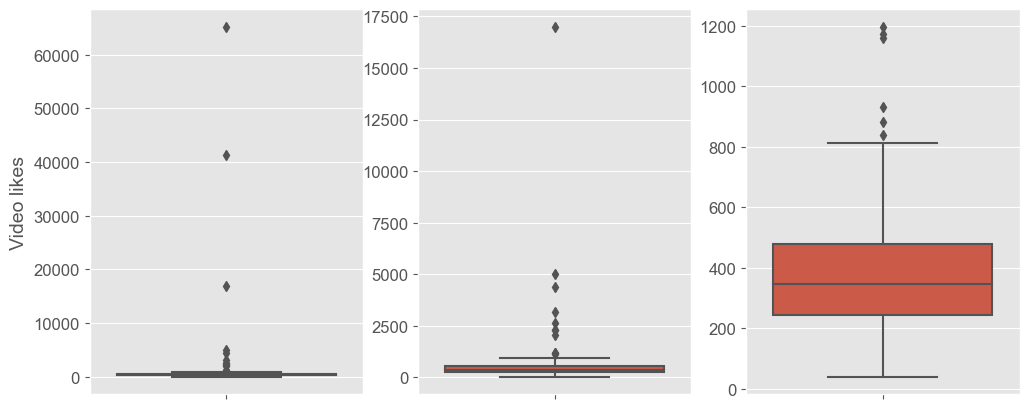

In [11]:
media_out_int = media_all.loc[(media_all["video_likes"] < 20000)]
media_out = media_all.loc[(media_all["video_likes"] < 1500)]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
sns.boxplot(y="video_likes", data=media_all, ax=axes[0])
sns.boxplot(y="video_likes", data=media_out_int, ax=axes[1])
sns.boxplot(y="video_likes", data=media_out, ax=axes[2])

axes[0].set_ylabel("Video likes")
axes[1].set_ylabel("")
axes[2].set_ylabel("");

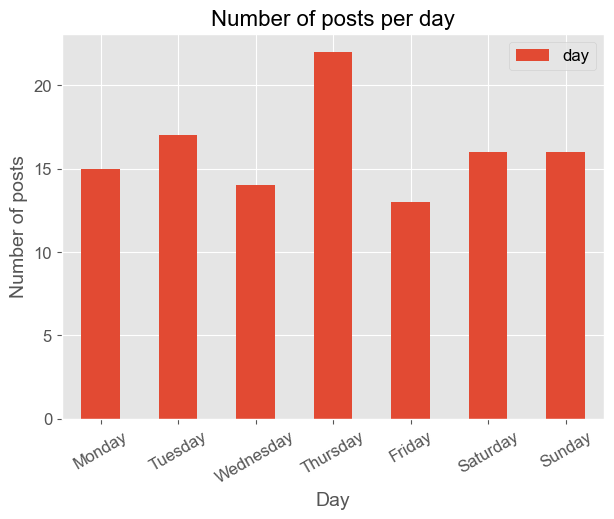

In [12]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
fig, ax = plt.subplots(figsize=(7, 5))
media_out["day"].value_counts().to_frame().sort_index().plot(
    kind="bar",
    ax=ax,
    xlabel="Day",
    ylabel="Number of posts",
    title="Number of posts per day",
)

ax.set_xticklabels(days, rotation=30);

<AxesSubplot: xlabel='day', ylabel='video_likes'>

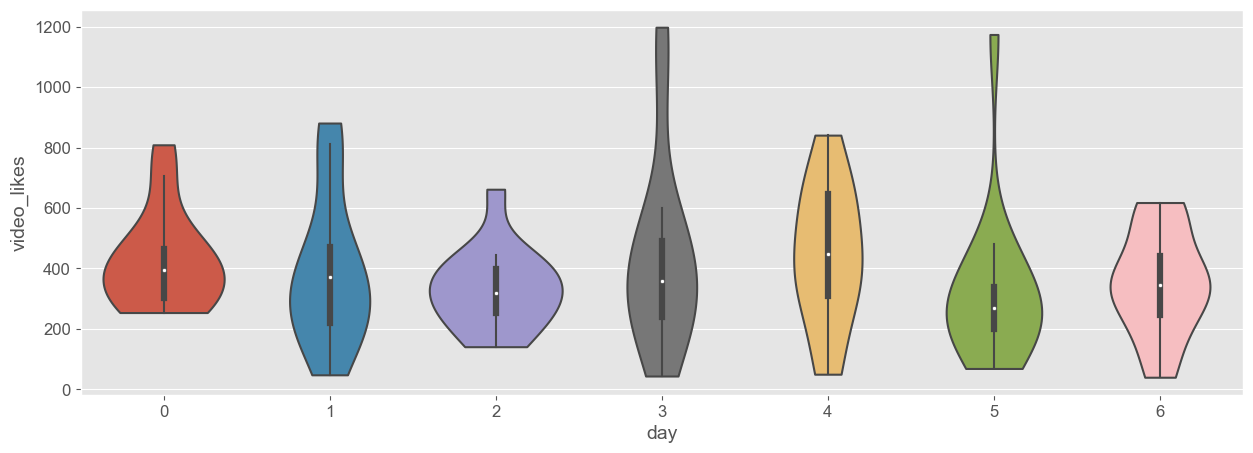

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.violinplot(x="day", y="video_likes", data=media_out, cut=0, ax=ax)

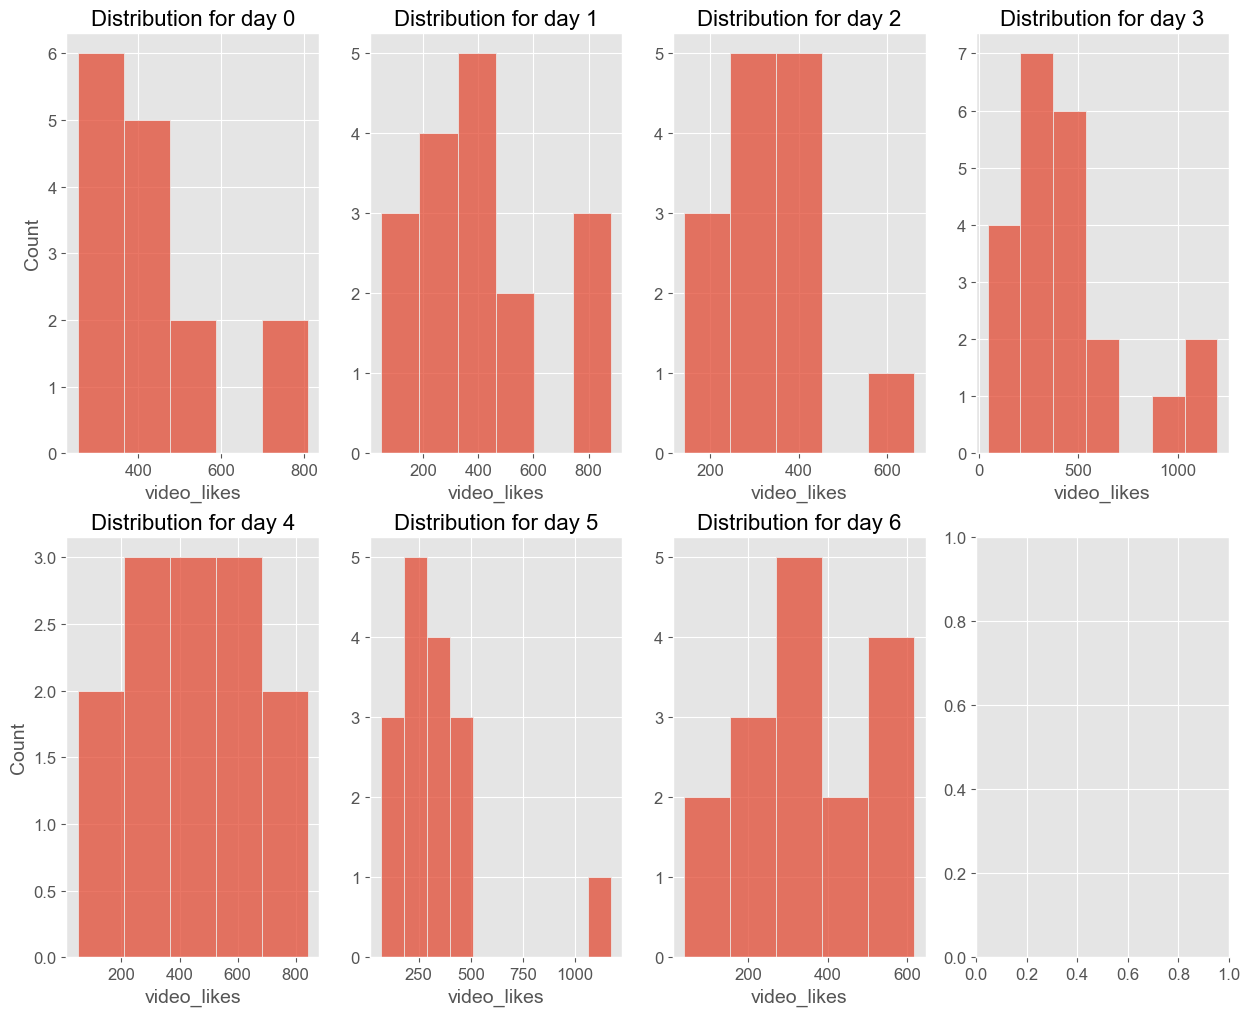

In [14]:
# sns.displot(data=media_out, x="video_likes", col="hour")
day_list = [0,1,2,3,4,5,6]
fig, axes = plt.subplots(2,4, figsize=(15,12))
axes = axes.ravel()

for i, (ax,day) in enumerate(zip(axes, range(7))):
    sns.histplot(media_out.loc[media_out["day"] == day]["video_likes"], ax=ax)
    
    ax.set_title(f"Distribution for day {day}")
    
    if i == 0 or i == 4:
        ax.set_ylabel("Count")
    else:
        ax.set_ylabel("")

## Statistical analysis

[statsmodelsANOVA](https://www.statsmodels.org/dev/generated/statsmodels.stats.oneway.anova_oneway.html#generated-statsmodels-stats-oneway-anova-oneway--page-root)

In [15]:
# Perform one-way non-parametric ANOVA test
day_0 = media_out.query("day == 0")["video_likes"]
day_1 = media_out.query("day == 1")["video_likes"]
day_2 = media_out.query("day == 2")["video_likes"]
day_3 = media_out.query("day == 3")["video_likes"]
day_4 = media_out.query("day == 4")["video_likes"]
day_5 = media_out.query("day == 5")["video_likes"]
day_6 = media_out.query("day == 6")["video_likes"]
H, p = stats.kruskal(day_0, day_1, day_2, day_3, day_4, day_5, day_6)

print(f"F-statistic of the one-way non-parametric ANOVA: {H:.2f}")
print(f"p-value a one-way non-parametric ANOVA: {p:.2f}")

F-statistic of the one-way non-parametric ANOVA: 7.42
p-value a one-way non-parametric ANOVA: 0.28


In [16]:
# Perform one-way parametric ANOVA test
F, p = sm.stats.anova_oneway(media_out["video_likes"], media_out["day"])

# Print the results
print(f"F-statistic of Welch ANOVA: {F:.2f}")
print(f"p-value of Welch ANOVA: {p:.2f}")

F-statistic of Welch ANOVA: 0.95
p-value of Welch ANOVA: 0.47


I checked the variance before performing the ANOVA test, which shows that the asusmption of homocedasticidity doesn't seem accurate for this data. However, what if we I had rushed things and not checked the variance? In that case, I would have used a simple one-way ANOVA test that assumes that the population standard deviations of the groups are equal (see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html) for more information)

The results are consistent in that we have very weak evidence agains the null hypothesis, but the resulting p-values differ significantly. This could have been a problem is the difference were close to the significance level. 

However, I'm a very stubborn person and I believe that day 5 has a significantly different mean than the other days. Let's compare two days on their own, such as day 5 and day 1:

In [17]:
# non-parametric test to compare two samples
U, p = stats.mannwhitneyu(day_1, day_5)

# Print the results
print("T-statistic:", U)
print("p-value:", p)

T-statistic: 166.0
p-value: 0.2878618137881952


In [18]:
T, p = stats.ttest_ind(day_1, day_5, equal_var=False)

# Print the results
print("T-statistic:", T)
print("p-value:", p)

T-statistic: 0.7973780766093379
p-value: 0.4313701839080535


The p-value is lower, but still far from the significance level. Still, there's weak evidence against the null hypotheis that the mean number of likes is the same regarless of the day when the post is shared. Therefore, we fail to reject the null hypothesis and one can claim that the day when the post is shared on Instagram doesn't affect the mean number of likes.

<a id='hour'></a>
# Does the hour when the post is shared make a difference?

## Understanding the data

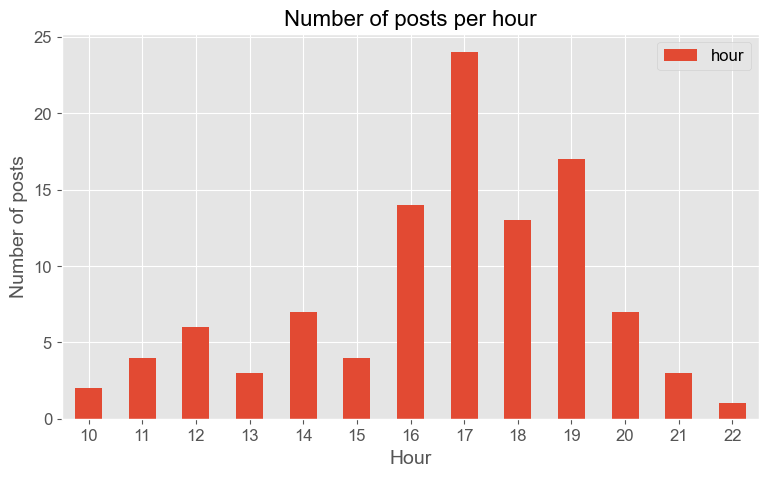

In [19]:
media_out = media_all.loc[(media_all["video_likes"] < 800)]

hour_df = media_out["hour"].value_counts().to_frame().sort_index()

hour_df.plot(
    kind="bar",
    figsize=(9, 5),
    ylabel="Number of posts",
    xlabel="Hour",
    title="Number of posts per hour",
    rot=0,
);

In [20]:
hour_include = hour_df.query("hour > 2").index.to_list()
media_out = media_all.loc[
    (media_all["video_likes"] < 1500)
    & media_out["hour"].isin(hour_include)
]

In [21]:
media_out.groupby("hour")["video_likes"].agg(["mean", "std", "var", "size"])

,mean,std,var,size
hour,,,,
11,244.750000,265.944073,70726.250000,4
12,273.833333,162.248472,26324.566667,6
13,291.333333,137.026761,18776.333333,3
14,364.000000,167.756768,28142.333333,7
15,258.750000,198.602409,39442.916667,4
16,382.214286,125.962252,15866.489011,14
17,376.833333,147.475766,21749.101449,24
18,383.461538,177.374658,31461.769231,13
19,318.235294,126.563981,16018.441176,17


<AxesSubplot: xlabel='hour', ylabel='video_likes'>

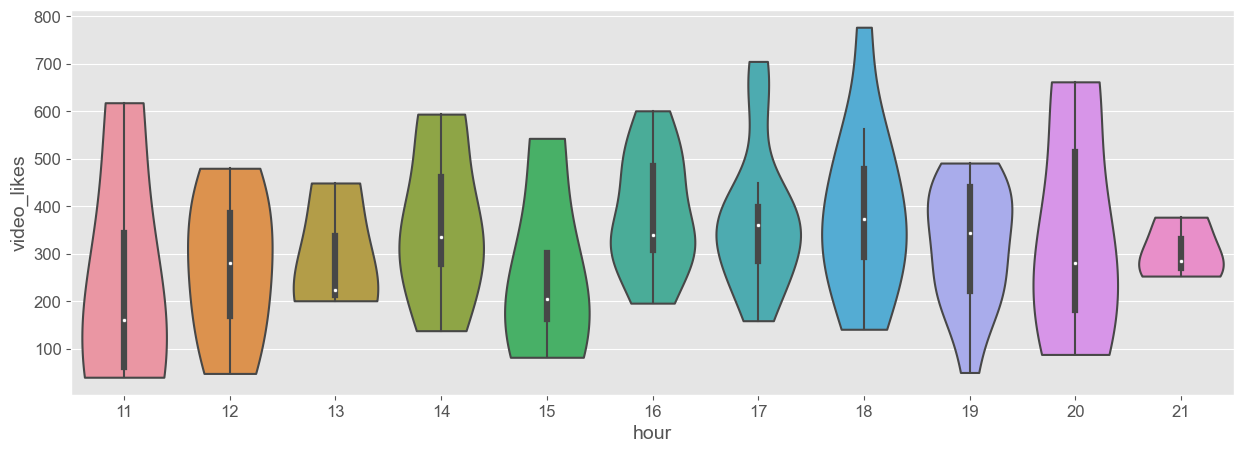

In [22]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.violinplot(x="hour", y="video_likes", data=media_out, ax=ax, cut=0, scale="width")

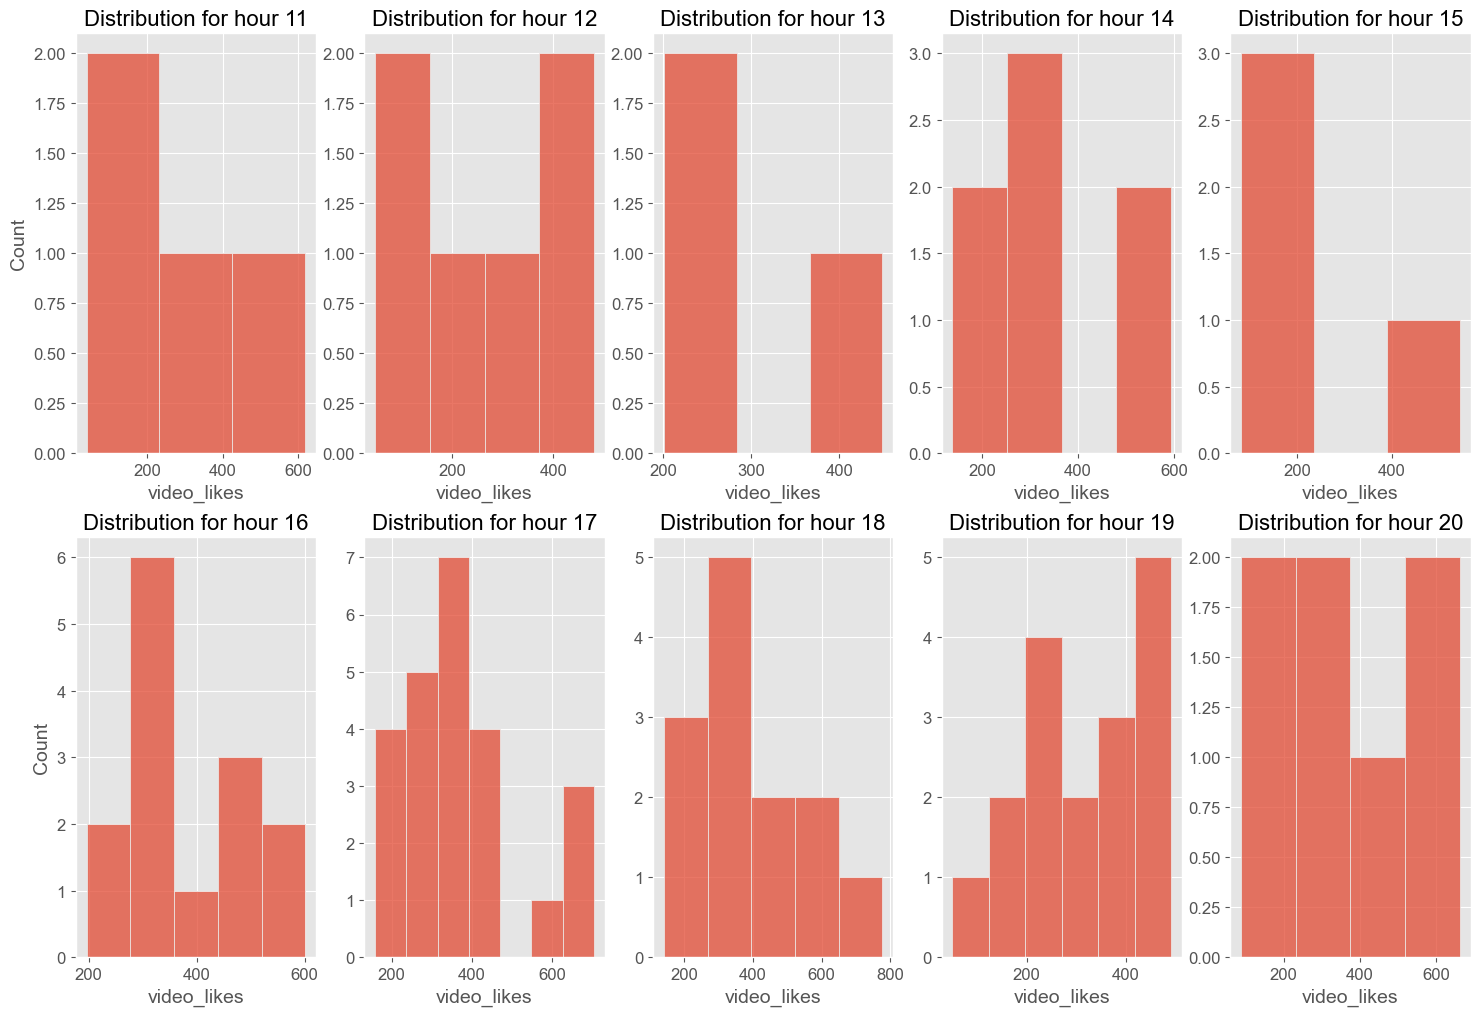

In [23]:
# sns.displot(data=media_out, x="video_likes", col="hour")

fig, axes = plt.subplots(2,5, figsize=(18,12))
axes = axes.ravel()

for i, (ax, hour) in enumerate(zip(axes, hour_include)):
    sns.histplot(media_out.loc[media_out["hour"] == hour]["video_likes"], ax=ax)
    
    ax.set_title(f"Distribution for hour {hour}")
    
    if i == 0 or i == 5:
        ax.set_ylabel("Count")
    else:
        ax.set_ylabel("")

In [24]:
# Perform one-way non-parametric ANOVA test
hour_values = []
for i, hour in enumerate(hour_include):
    hour_values.append(media_out.loc[media_out["hour"] == hour]["video_likes"].to_list())

H, p = stats.kruskal(*hour_values)

print(f"F-statistic of the one-way non-parametric ANOVA: {H:.2f}")
print(f"p-value a one-way non-parametric ANOVA: {p:.2f}")

F-statistic of the one-way non-parametric ANOVA: 7.29
p-value a one-way non-parametric ANOVA: 0.70


In [25]:
# Perform one-way parametric ANOVA test
F, p = sm.stats.anova_oneway(media_out["video_likes"], media_out["hour"])

# Print the results
print(f"F-statistic of Welch ANOVA: {F:.2f}")
print(f"p-value of Welch ANOVA: {p:.2f}")

F-statistic of Welch ANOVA: 0.60
p-value of Welch ANOVA: 0.80


In [26]:
media_out.groupby("hour")["video_likes"].agg(["mean", "std", "size"])

,mean,std,size
hour,,,
11,244.750000,265.944073,4
12,273.833333,162.248472,6
13,291.333333,137.026761,3
14,364.000000,167.756768,7
15,258.750000,198.602409,4
16,382.214286,125.962252,14
17,376.833333,147.475766,24
18,383.461538,177.374658,13
19,318.235294,126.563981,17


In [27]:
pd.crosstab(media_out["hour"], media_out["day"])

day,0,1,2,3,4,5,6
hour,,,,,,,
11,0,0,0,0,0,1,3
12,0,1,0,0,0,4,1
13,0,0,0,0,0,2,1
14,0,0,0,0,0,2,5
15,0,0,0,0,0,1,3
16,4,2,0,4,1,2,1
17,3,3,5,6,5,1,1
18,0,3,6,2,1,1,0
19,6,3,1,3,3,0,1


### Analysing the hashtags

In [28]:
media_out = media_all.loc[(media_all["video_likes"] < 800)]

media_out.groupby("core_hashtags")["video_likes"].agg(["mean", "std", "size"])

,mean,std,size
core_hashtags,,,
False,365.172414,176.349647,58
True,317.957447,133.376870,47


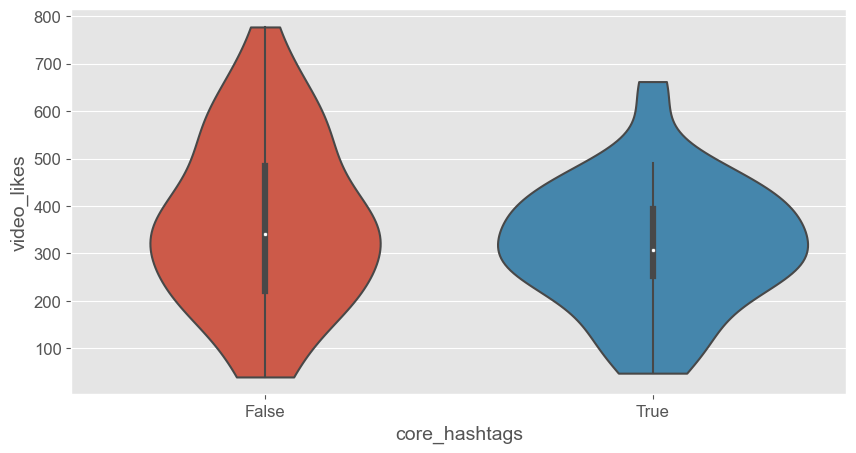

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.violinplot(x="core_hashtags", y="video_likes", data=media_out, ax=ax, cut=0);

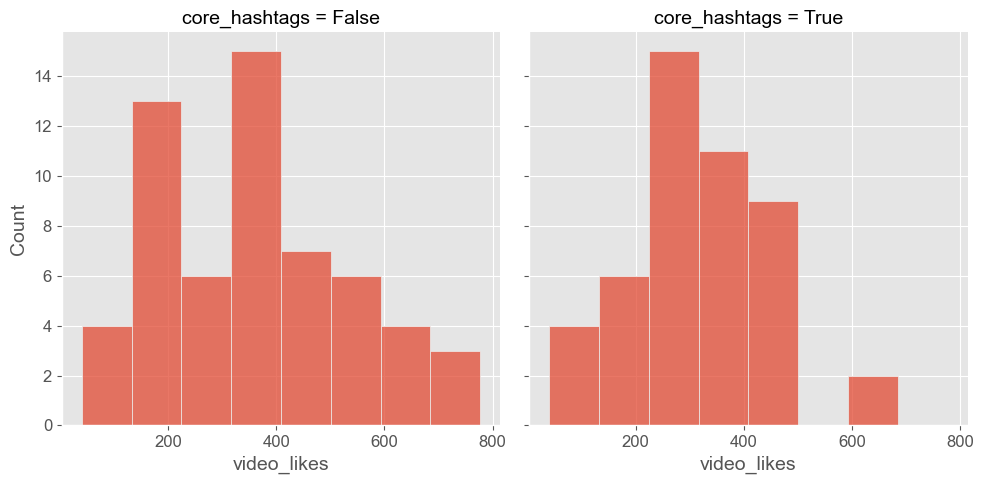

In [30]:
sns.displot(kind="hist", x="video_likes", col="core_hashtags", data=media_out);

In [31]:
# Perform the Mann-Whitney U rank test
U, p = stats.mannwhitneyu(
    media_out.query("core_hashtags == True")["video_likes"],
    media_out.query("core_hashtags == False")["video_likes"]
)

# Print the results
print(f"Test statistic of Mann-Whitney U rank test: {U:.2f}")
print(f"p-value of Mann-Whitney U rank: {p:.2f}")

Test statistic of Mann-Whitney U rank test: 1188.00
p-value of Mann-Whitney U rank: 0.26


### Analysis of pictures

In [32]:
image_df = media_all.loc[
    (media_all["media_type"] == "CAROUSEL_ALBUM") | (media_all["media_type"] == "IMAGE")
]

<AxesSubplot: ylabel='Frequency'>

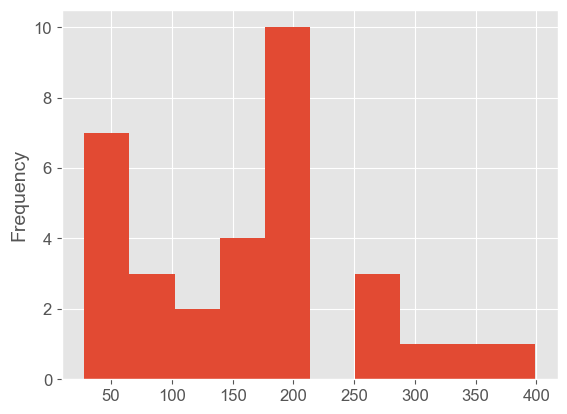

In [33]:
image_df["engagement"].plot(kind="hist")

<AxesSubplot: xlabel='date'>

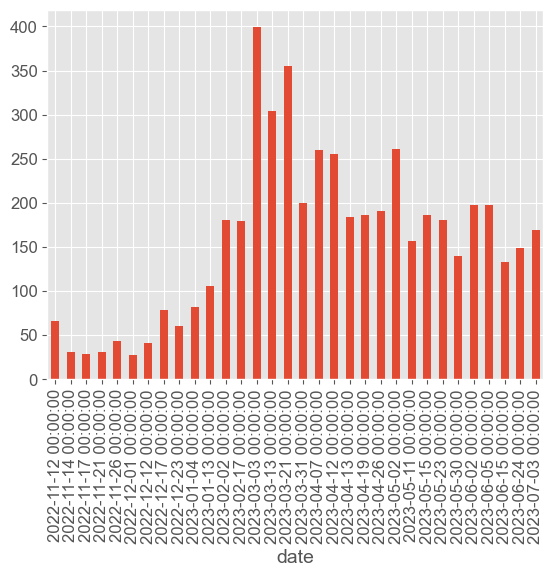

In [34]:
image_date = image_df.copy()
image_date["date"] = pd.to_datetime(image_date["date"])

image_date.set_index("date", inplace=True)
image_date.sort_index(ascending=True, inplace=True)
image_date["engagement"].plot(kind="bar")